In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [ ]:
# importing the data
df = pd.read_csv('final_df.csv',infer_datetime_format=True,
                    index_col=['datetime'])
df.index = pd.to_datetime(df.index)
print(df.shape)
df.head(2)

(2007305, 8)


,global_active_power,voltage,year,quarter,month,day,temperature,weekday
datetime,,,,,,,,
2007-01-01 00:00:00,2.5800,241.9700,2007,1,1,1,13.3000,1
2007-01-01 00:01:00,2.5520,241.7500,2007,1,1,1,13.3000,1


Fourier Transformation

For data that has seasonal, or daily patterns, we can use Fourier analysis to make predictions

It is a combinatin of extrapolation and denoising

Step 1: Compute the FFT of the singal using fft() function

Step 2: Take the square of the absolute value of FFT in order to get the power spectral density (PSD)

In [ ]:
global_active_power_fft = np.fft.fft(np.asarray(df.global_active_power.tolist()))
fft_df = pd.DataFrame({'fft':global_active_power_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

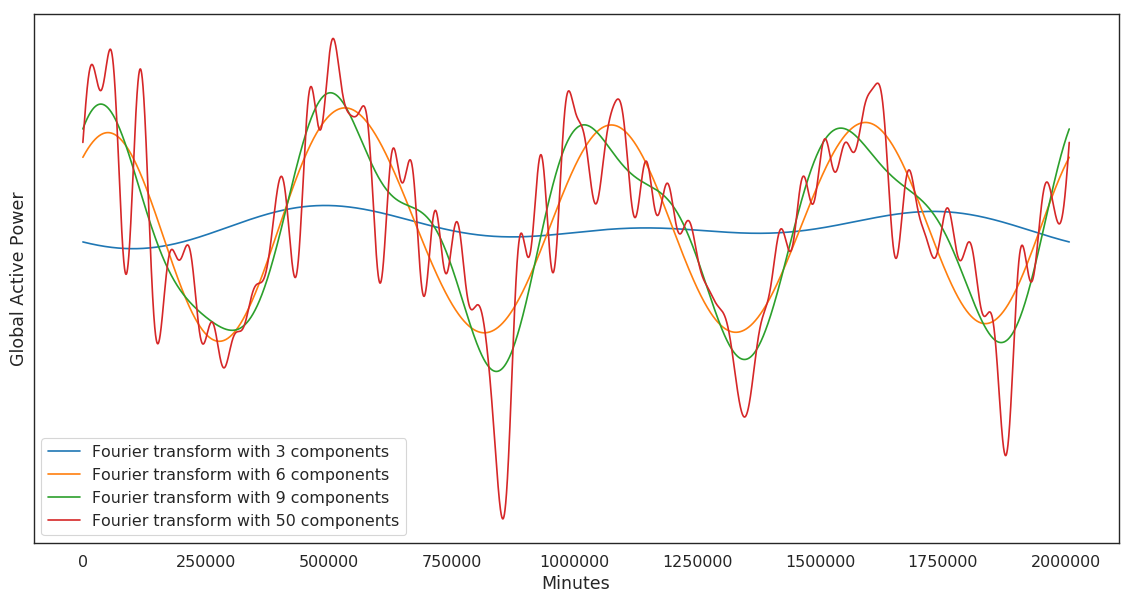

In [5]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for i in [3, 6, 9, 50]:
    fft_list_m10 = np.copy(fft_list); fft_list_m10[i:-i]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(i))
plt.xlabel('Minutes')
plt.ylabel('Global Active Power')
plt.yticks([])
plt.legend()
plt.show();


Fourier Transoformations smoothens the data better by denoising

Data Preparation for RNN

In [3]:
df.columns

Index(['global_active_power', 'voltage', 'year', 'quarter', 'month', 'day',
       'temperature', 'weekday'],
      dtype='object')

In [23]:
categorical_columns = ['year', 'quarter', 'month', 'day', 'weekday']

def one_hot(df, cols):
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df, dummies], axis=1)
    return df

df = one_hot(df, categorical_columns)

In [24]:
# now need to drop the categorical columns because they are one-hot encoded
df.drop(columns = categorical_columns, inplace=True)
df.head(3)

,global_active_power,voltage,temperature,year_2008,year_2009,year_2010,quarter_2,quarter_3,quarter_4,month_2,...,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,weekday_1
datetime,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,2.5800,241.9700,13.3000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2007-01-01 00:01:00,2.5520,241.7500,13.3000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2007-01-01 00:02:00,2.5500,241.6400,13.3000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
# df.global_active_power = df.global_active_power.astype('float32')
# df.voltage = df.voltage.astype('float32')
# df.temperature = df.voltage.astype('float32')

data = df.values
data = data.astype('float32')

In [26]:
# scaling
minmax = MinMaxScaler(feature_range=(0, 1))
scaled = minmax.fit_transform(data)
scaled = pd.DataFrame(scaled)
scaled.head(3)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.2267,0.6065,0.5232,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,0.2242,0.5994,0.5232,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2,0.2240,0.5958,0.5232,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [27]:
def time_series_dataset(data, look_back=1, pred_col=0):
    ts = data.copy()
    ts['id'] = range(1, len(ts)+1)
    ts = ts.iloc[:-look_back, :]
    ts.set_index('id', inplace=True)
    pred = data.copy()
    pred = pred.iloc[look_back:, pred_col]
    pred.columns = ['pred']
    pred = pd.DataFrame(pred)
    
    pred['id'] = range(1, len(pred)+1)
    pred.set_index('id', inplace=True)
    final_df = pd.concat([ts, pred], axis = 1)
    
    return final_df

In [28]:
arr_df = time_series_dataset(scaled, 30, 0)
arr_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,0
id,,,,,,,,,,,,,,,,,,,,,
1,0.2267,0.6065,0.5232,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.2328
2,0.2242,0.5994,0.5232,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.2327


In [29]:
# splitting into train and test sets
values = arr_df.values
train_size = int(len(data) * 0.8)
test_size = int(len(data)) - train_size

train = values[:train_size,:]
test = values[train_size:,:]

# splitting into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1605844, 51) (1605844,) (401431, 51) (401431,)


In [30]:
# reshaping 3D tensor with format [sample size, timesteps, features]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1605844, 51, 1) (1605844,) (401431, 51, 1) (401431,)


## LSTM Model

Creating the LSTM model with 3 LSTM layers and one Dense layer

In [12]:
model = Sequential()
model.add(LSTM(100, return_sequences=True,
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 51, 100)           40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train, y_train, epochs=5, batch_size=70, 
                   validation_data=(X_test, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                    verbose=1, shuffle=False)

Train on 1605844 samples, validate on 401431 samples
Epoch 1/5
1605844/1605844 [==============================] - 2409s 1ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 2/5
1605844/1605844 [==============================] - 2402s 1ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 3/5
1605844/1605844 [==============================] - 2433s 2ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 4/5
1605844/1605844 [==============================] - 2481s 2ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 5/5
1605844/1605844 [==============================] - 2467s 2ms/step - loss: 0.0089 - val_loss: 0.0091


In [31]:
# making predictions
# for test data
test_predict = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
# for train data
train_predict = model.predict(X_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))

# invert test predictions
inv_test_predict = np.concatenate((test_predict, X_test[:, 1:]), axis=1)
inv_test_predict = minmax.inverse_transform(inv_test_predict)
inv_test_predict = inv_test_predict[:,0]

# invert train predictions
inv_train_predict = np.concatenate((train_predict, X_train[:, 1:]), axis=1)
inv_train_predict = minmax.inverse_transform(inv_train_predict)
inv_train_predict = inv_train_predict[:,0]

# invert scaling for true values
y_test = y_test.reshape((len(y_test), 1))
inv_y_test = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y_test = minmax.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:, 0]

# invert scaling for true y_train
y_train = y_train.reshape((len(y_train), 1))
inv_y_train = np.concatenate((y_train, X_train[:, 1:]), axis=1)
inv_y_train = minmax.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:, 0]

print('Train Mean Absolute Error:', mean_absolute_error(inv_y_train, inv_train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(inv_y_train, inv_train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(inv_y_test, inv_test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(inv_y_test, inv_test_predict)))

Train Mean Absolute Error: 0.9790742
Train Root Mean Squared Error: 1.1786834
Test Mean Absolute Error: 0.8843452
Test Root Mean Squared Error: 1.0549445


In [21]:
X_test.shape

(401431, 51)

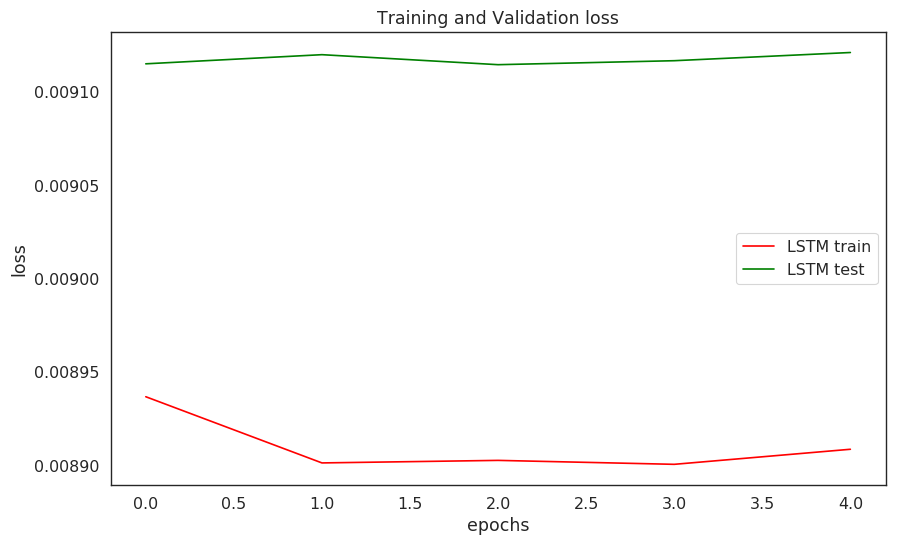

In [32]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(history.history['loss'], label='LSTM train', color='red')
plt.plot(history.history['val_loss'], label='LSTM test', color= 'green')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

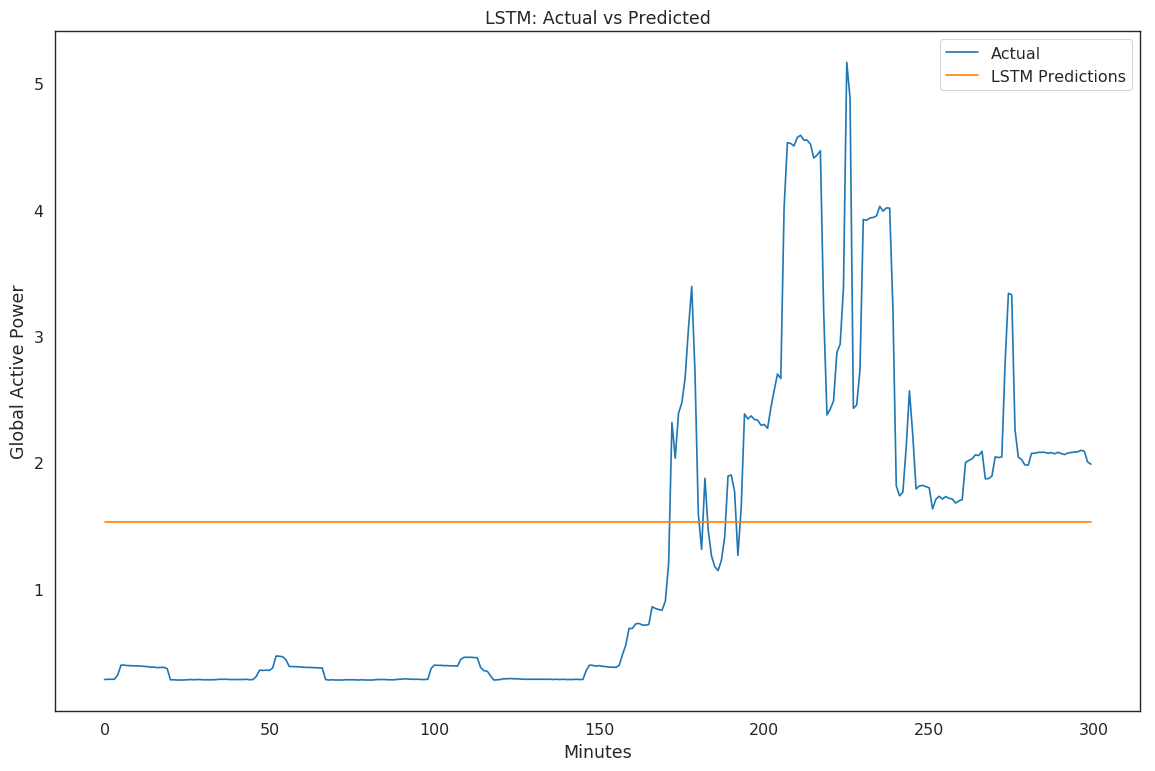

In [34]:
plt.figure(figsize=(14,9), dpi=100)
plt.plot(inv_y_test[:300], label='Actual')
plt.plot(inv_test_predict[:300], label='LSTM Predictions')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('Minutes')
plt.ylabel('Global Active Power')
plt.legend()
plt.show();

In [38]:
test_predict[:4]

array([[0.13176098],
       [0.13176098],
       [0.13176098],
       [0.13176098]], dtype=float32)

In [39]:
from keras.models import save_model

model.save('lstm_model_2.h5')